<!-- ---
reviewed_on: "2024-12-16"
--- -->

# Last presentation tests

## Import necessary packages

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim

## Loading the dataset

In [24]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(),
								transforms.Normalize((0.4919, 0.4827, 0.4472),
														(0.2022, 0.1994, 0.2010)),
								])

trainset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Defining the network

In [25]:
class Network(nn.Module):
	def __init__(self):
		super().__init__()

		self.fc1 = nn.Linear(3072, 1024)
		self.fc2 = nn.Linear(1024, 512)
		self.fc3 = nn.Linear(512, 256)
		self.fc4 = nn.Linear(256, 10)

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = x.view(x.shape[0], -1)

		x = self.dropout(F.relu(self.fc1(x)))
		x = self.dropout(F.relu(self.fc2(x)))
		x = self.dropout(F.relu(self.fc3(x)))

		x = F.log_softmax(self.fc4(x), dim=1)

		return x

## Training network

In [26]:
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

In [27]:
epochs = 15

train_losses, test_losses = [], []
for e in range(epochs):
	running_loss = 0
	network.train()
	for images, labels in trainloader:
		optimizer.zero_grad()

		log_ps = network(images)
		loss = criterion(log_ps, labels)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()
	else:
		test_loss = 0
		accuracy = 0

		# Turn off gradients for validation, saves memory and computations
		with torch.no_grad():
			network.eval()
			for images, labels in testloader:
				log_ps = network(images)
				test_loss += criterion(log_ps, labels)

				ps = torch.exp(log_ps)
				top_p, top_class = ps.topk(1, dim=1)
				equals = top_class == labels.view(*top_class.shape)
				accuracy += torch.mean(equals.type(torch.FloatTensor))

		train_losses.append(running_loss / len(trainloader))
		test_losses.append(test_loss / len(testloader))

		print("Epoch: {}/{} ".format(e + 1, epochs),
				"Training Loss: {:.3f} ".format(train_losses[-1]),
				"Test Loss: {:.3f} ".format(test_losses[-1]),
				"Test Accuracy: {:.3f} ".format(accuracy / len(testloader)))

Epoch: 1/15  Training Loss: 1.725  Test Loss: 1.535  Test Accuracy: 0.458 
Epoch: 2/15  Training Loss: 1.512  Test Loss: 1.444  Test Accuracy: 0.496 
Epoch: 3/15  Training Loss: 1.416  Test Loss: 1.379  Test Accuracy: 0.514 
Epoch: 4/15  Training Loss: 1.342  Test Loss: 1.363  Test Accuracy: 0.519 
Epoch: 5/15  Training Loss: 1.282  Test Loss: 1.331  Test Accuracy: 0.534 
Epoch: 6/15  Training Loss: 1.228  Test Loss: 1.303  Test Accuracy: 0.540 
Epoch: 7/15  Training Loss: 1.172  Test Loss: 1.281  Test Accuracy: 0.550 
Epoch: 8/15  Training Loss: 1.128  Test Loss: 1.280  Test Accuracy: 0.556 
Epoch: 9/15  Training Loss: 1.082  Test Loss: 1.265  Test Accuracy: 0.562 
Epoch: 10/15  Training Loss: 1.040  Test Loss: 1.260  Test Accuracy: 0.564 
Epoch: 11/15  Training Loss: 1.000  Test Loss: 1.262  Test Accuracy: 0.562 
Epoch: 12/15  Training Loss: 0.958  Test Loss: 1.260  Test Accuracy: 0.563 
Epoch: 13/15  Training Loss: 0.921  Test Loss: 1.269  Test Accuracy: 0.568 
Epoch: 14/15  Trainin

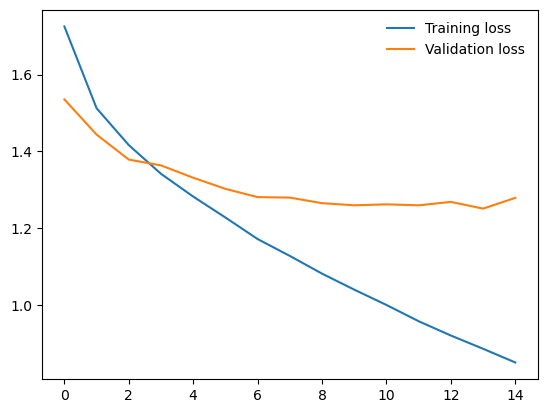

In [29]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)

## Saving the networks

In [30]:
torch.save(network.state_dict(), "checkpoint.pth")